# Titanic

### Importamos librerias

In [2]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict;
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict;
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix;
from sklearn.metrics import precision_recall_curve;
from sklearn.metrics import roc_curve;
from sklearn.metrics import roc_auc_score;
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix;
import os
np.random.seed(42)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Primera observacion de los datos

In [3]:
titanic_origen = pd.read_csv("./datasets/titanic.xls")
titanic_origen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [4]:
titanic_origen.duplicated().sum()

0

- Hay 5 columnas categoricas.
- No hay valores duplicados.
- Hay columnas como PassengerId, Name, Ticket que no tienen un valor importante a la hora de clasificar. Las eliminaremos.
- Hay varios valores nulos en las columnas Age y Fare. En Cabin tambien, sin embargo la eliminaremos porque apenas tiene valores.

In [5]:
titanic_origen.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Corrigiendo valores NaN

- Vamos a crear una copia para no alterar el dataset original

In [6]:
titanic = titanic_origen.copy()

In [7]:
for col in ["Age", "Fare"]:
    media = titanic[col].median()
    titanic[col].fillna(media, inplace=True)

In [8]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          418 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         418 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


#### Eliminando columnas innecesarias

In [9]:
titanic.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"], axis=1, inplace=True)

In [10]:
titanic.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

#### Estudiando los datos con graficas

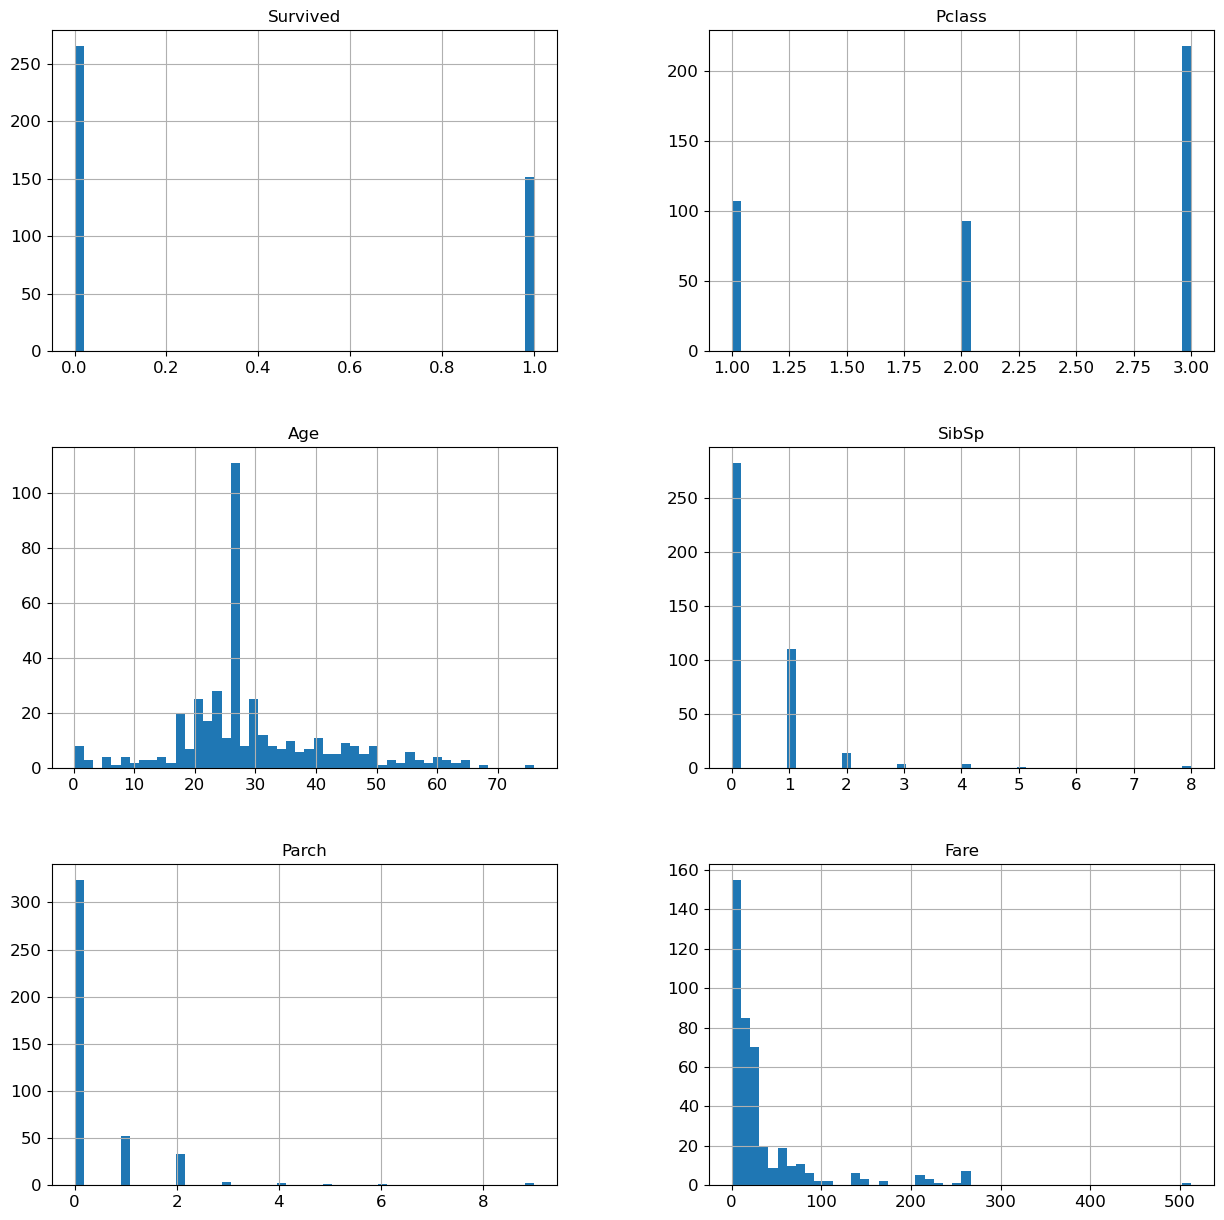

In [11]:
titanic.hist(bins=50, figsize=(15,15));

In [12]:
def categorizar_edad(edad):
    if edad < 18:
        return 'joven'
    else:
        return 'adulto'

In [13]:
copy = titanic.copy()
copy["Edad"] = copy['Age'].apply(categorizar_edad)


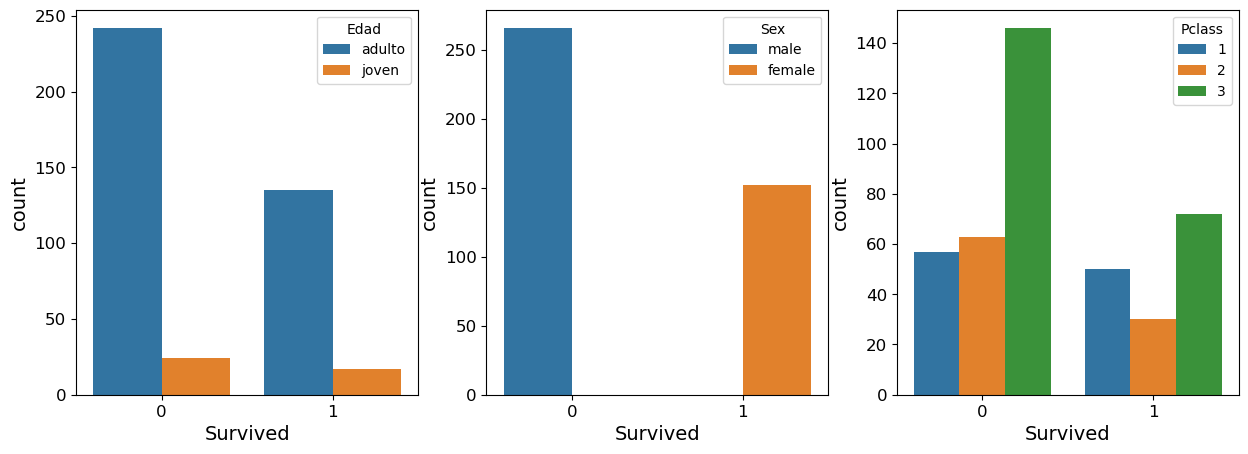

In [152]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
sns.countplot(x='Survived', hue = 'Edad',data=copy, ax=axs[0])
sns.countplot(x='Survived', hue = 'Sex',data=titanic_origen, ax=axs[1])
sns.countplot(x='Survived', hue = 'Pclass',data=titanic, ax=axs[2])
plt.show()

#### Descategorizando columnas
- Vamos a utilizar la clase OneHotEncoder para transformar cada valor de cada columna en una nueva columna con valores binarios (0 y 1).

In [15]:
titanic_cat = titanic[["Embarked", "Sex"]]
titanic_cat

,Embarked,Sex
0,Q,male
1,S,female
2,Q,male
3,S,male
4,S,female
...,...,...
413,S,male
414,C,female
415,S,male
416,S,male


In [16]:
for col in titanic_cat.columns:
    oneHot_encoder = OneHotEncoder(sparse=False)
    cat_1hot_encoded = oneHot_encoder.fit_transform(titanic_cat[[col]])
    titanic.reset_index(drop=False, inplace=True)
    titanic=titanic.join(pd.DataFrame(cat_1hot_encoded, columns=[cat for cat in oneHot_encoder.categories_[0]]))
    titanic=titanic.drop([col,'index'], axis=1);

In [17]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  418 non-null    int64  
 1   Pclass    418 non-null    int64  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   C         418 non-null    float64
 7   Q         418 non-null    float64
 8   S         418 non-null    float64
 9   female    418 non-null    float64
 10  male      418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


### Analizamos correlaciones
- Las correlaciones nos mostraran que variable esta mas relacionada con la supervivencia.

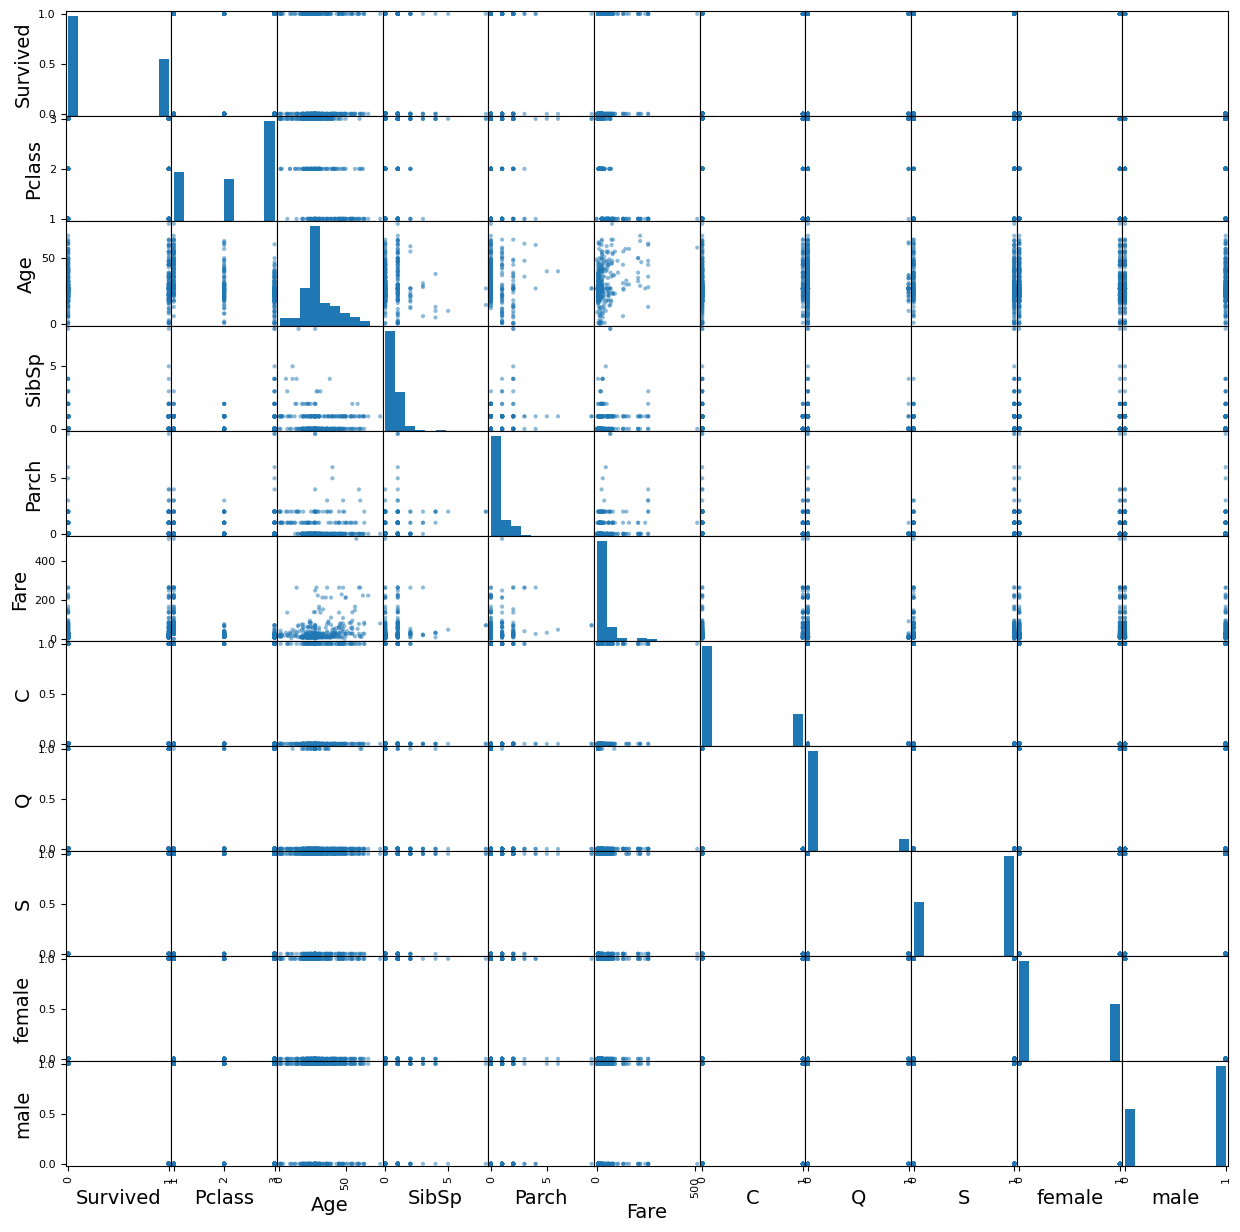

In [18]:
scatter_matrix(titanic, figsize=(15, 15));

In [19]:
corr_matrix = titanic.corr();

In [20]:
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
female      1.000000
Fare        0.192036
Parch       0.159120
Q           0.115574
SibSp       0.099943
C           0.033684
Age         0.008035
S          -0.105883
Pclass     -0.108615
male       -1.000000
Name: Survived, dtype: float64

### Preparando los conjuntos de entrenamiento y validacion

- Dividimos los los datos en datos de entreno (80%) y validacion (20%);

In [132]:
X_train, X_test = train_test_split(titanic, test_size=0.25, random_state=42)
len(X_train), len(X_test)

(313, 105)

- Creamos una variable del conjunto de resultados de entreno y eliminamos estos del conjunto de entreno.

In [133]:
y_train = X_train["Survived"].copy()
X_train = X_train.copy().drop("Survived", axis=1)

- Creamos una variable del conjunto de resultados de validacion y eliminamos estos del conjunto de validacion.

In [134]:
y_test = X_test["Survived"].copy()
X_test = X_test.copy().drop("Survived", axis=1)

- Generamos una muestra de tres instancias aleatorias para ver comodamente las predicciones.

In [135]:
some_data = X_test.sample(3)

In [136]:
len(y_train), len(y_test)

(313, 105)

### Entrenando modelos

#### *SGDClassifier*: El SGD es un modelo de clasificacion binaria basado en el descenso del gradiente estocastico.

In [137]:
sgd_clf = SGDClassifier(penalty='l1', alpha=0.1, random_state=42)
sgd_clf.fit(X_train, y_train)
y_pred_sgd1 = sgd_clf.predict(X_test)
y_pred_sgd1

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [138]:
sgd_score = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
sgd_score.mean()

0.907051282051282

In [139]:
y_pred_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_pred_sgd)

array([[188,   9],
       [ 20,  96]], dtype=int64)

In [140]:
precision = precision_score(y_train, y_pred_sgd)
recall = recall_score(y_train, y_pred_sgd)
f1 = f1_score(y_train, y_pred_sgd)

precision, recall, f1

(0.9142857142857143, 0.8275862068965517, 0.8687782805429863)

In [141]:
precision = precision_score(y_test, y_pred_sgd1)
recall = recall_score(y_test, y_pred_sgd1)
f1 = f1_score(y_test, y_pred_sgd1)

precision, recall, f1

(1.0, 1.0, 1.0)

#### Precision vs Recall

In [148]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function");

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores);

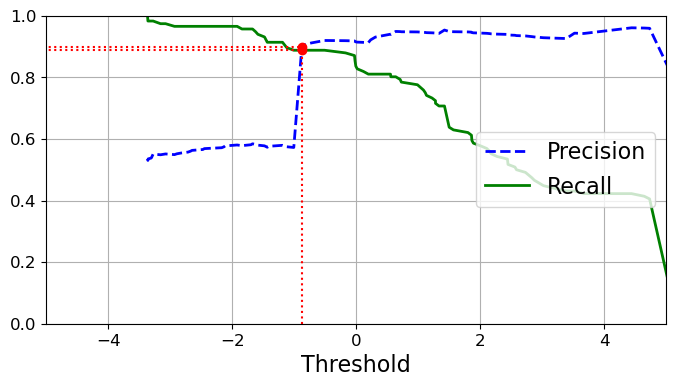

In [154]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2);
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2);
    plt.legend(loc="center right", fontsize=16);
    plt.xlabel("Threshold", fontsize=16);
    plt.grid(True);
    plt.axis([-5, 5, 0, 1]);

recall_90_precision = recalls[np.argmax(precisions >= 0.90)];
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)];

plt.figure(figsize=(8, 4));
plot_precision_recall_vs_threshold(precisions, recalls, thresholds);
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:");
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:");
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:");
plt.plot([threshold_90_precision], [0.9], "ro");
plt.plot([threshold_90_precision], [recall_90_precision], "ro");
plt.show();

#### Curva ROC del SGD
- La curva ROC es una grafica que ,en lugar de representar la precision contra la sensibilidad como hacia la anterior grafica, representa el ratio de verdaderos positivos (TPR) contra el ratio de falsos positivos (FPR).  
- Los umbrales (thresholds) son la linea que supone la puntuacion minima necesaria para para asignar una clase como positiva.

In [144]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores);
fpr, tpr, thresholds

(array([0.        , 0.        , 0.00507614, 0.00507614, 0.01015228,
        0.01015228, 0.01015228, 0.01015228, 0.01522843, 0.01522843,
        0.02030457, 0.02030457, 0.02030457, 0.02030457, 0.02030457,
        0.02030457, 0.02030457, 0.02030457, 0.02030457, 0.02538071,
        0.02538071, 0.02538071, 0.02538071, 0.03045685, 0.03045685,
        0.04568528, 0.04568528, 0.04568528, 0.04568528, 0.05583756,
        0.39086294, 0.39086294, 0.39086294, 0.40101523, 0.40101523,
        0.40101523, 0.41116751, 0.41116751, 0.46700508, 0.46700508,
        0.47208122, 0.47208122, 0.48730964, 0.50253807, 0.51269036,
        0.51269036, 0.55329949, 0.56345178, 0.57360406, 0.58883249,
        0.59898477, 0.60913706, 0.6142132 , 0.63451777, 0.64467005,
        0.64974619, 0.65989848, 0.66497462, 0.68527919, 0.70050761,
        0.72588832, 0.73604061, 0.74619289, 0.81725888, 0.82233503,
        0.83756345, 0.85786802, 0.87817259, 0.88832487, 0.89847716,
        0.92893401, 0.93908629, 0.97461929, 0.98

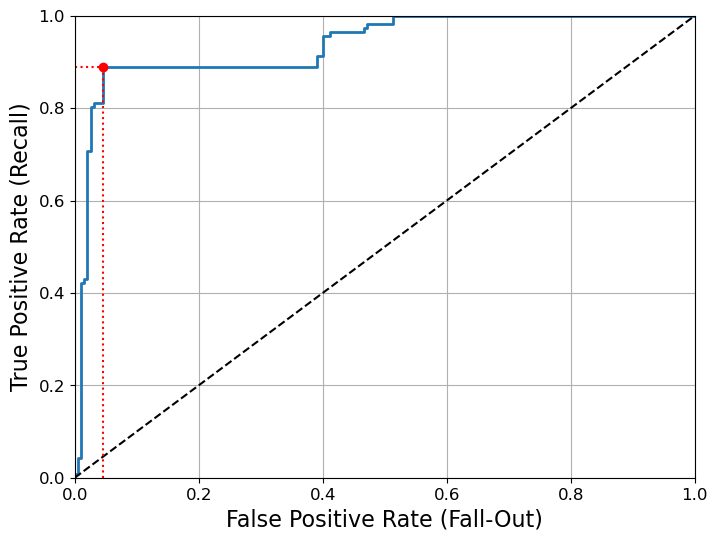

In [145]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label);
    plt.plot([0, 1], [0, 1], 'k--');
    plt.axis([0, 1, 0, 1]);
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16);
    plt.ylabel('True Positive Rate (Recall)', fontsize=16);
    plt.grid(True);

plt.figure(figsize=(8, 6));
plot_roc_curve(fpr, tpr);
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)];
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:");
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:");
plt.plot([fpr_90], [recall_90_precision], "ro");
plt.show();

#### Area bajo la curva ROC (AUC)
- Es util para valorar la calidad de clasificacion del modelo. Es mejor cuanto mayor se acerque a 1. Seria un mal modelo si su valor se acerca a 0.5, ya que seria tan insuficiente como un clasificador aleatorio.

In [146]:
roc_auc_score(y_train, y_scores)

0.9361543847365656